<a href="https://colab.research.google.com/github/Dyakonov/ml_hacks/blob/master/dj_Transfer_Learning202402.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

сделано по

* https://github.com/joe-papa/pytorch-book/blob/main/04_01_Transfer_Learning.ipynb
* (исходник - СМ) https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

В этом ноутбуке демонстрация  - как можно сделать трансферное обучение. В конце - задание осуществить своё трансфер.

## Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms

## Загрузка данных

будут в каталогах

* data/hymenoptera_data/train
* data/hymenoptera_data/val

In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('./data')

## преобразования картинок в тензоры + даталоадеры

Они соответствуют тем, которые были сделаны при обучении основной сети на датасете Imagenet

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456,0.406],
        [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])])

In [4]:
train_dataset = datasets.ImageFolder(
          root='data/hymenoptera_data/train',
          transform=train_transforms)

val_dataset = datasets.ImageFolder(
            root='data/hymenoptera_data/val',
            transform=val_transforms)

In [5]:
train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=4)

val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Модель

Берём обученную на 1000 классов сеть и заменяем головку на линейный модуль на нужное число выходов

In [6]:
model = models.resnet18(pretrained=True) # deprecated !!!

print(model.fc)
# out:
# Linear(in_features=512, out_features=1000, bias=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # ТУТ МЫ ДЕЛАЕМ НОВУЮ ГОЛОВКУ СЕТИ
print(model.fc)
# out:
# Linear(in_features=512, out_features=2, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=2, bias=True)


## Обучение

In [8]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # где учить

model = model.to(device) # переносим модель
criterion = nn.CrossEntropyLoss()  # функция ошибки
optimizer = optim.SGD(
                    model.parameters(),
                    lr=0.001,
                    momentum=0.9) # оптимизатор
exp_lr_scheduler = StepLR(optimizer,
                          step_size=7,
                          gamma=0.1) # через 7 шагов понижать темп

In [9]:
num_epochs=25 # число эпох

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    running_corrects = 0

    # ДАЛЬШЕ ОБЫЧНЫЙ ЦИКЛ ОБУЧЕНИЯ

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    exp_lr_scheduler.step()

    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval() # <3>
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)

    print("Train: Loss: {:.4f} Acc: {:.4f}"
          " Val: Loss: {:.4f}"
          " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: Loss: 0.1306 Acc: 0.7172 Val: Loss: 0.0750 Acc: 0.9038
Train: Loss: 0.1041 Acc: 0.8156 Val: Loss: 0.1405 Acc: 0.8333
Train: Loss: 0.1503 Acc: 0.7910 Val: Loss: 0.0968 Acc: 0.8526
Train: Loss: 0.1414 Acc: 0.7746 Val: Loss: 0.0963 Acc: 0.8526
Train: Loss: 0.0893 Acc: 0.8566 Val: Loss: 0.0954 Acc: 0.8397
Train: Loss: 0.0903 Acc: 0.8361 Val: Loss: 0.0557 Acc: 0.9295
Train: Loss: 0.0954 Acc: 0.8279 Val: Loss: 0.0735 Acc: 0.9103
Train: Loss: 0.1025 Acc: 0.8033 Val: Loss: 0.0689 Acc: 0.9103
Train: Loss: 0.0975 Acc: 0.8238 Val: Loss: 0.0591 Acc: 0.9231
Train: Loss: 0.0952 Acc: 0.8156 Val: Loss: 0.0625 Acc: 0.9167
Train: Loss: 0.0639 Acc: 0.9057 Val: Loss: 0.0554 Acc: 0.9231
Train: Loss: 0.0765 Acc: 0.8525 Val: Loss: 0.0611 Acc: 0.9103
Train: Loss: 0.0635 Acc: 0.8893 Val: Loss: 0.0540 Acc: 0.9231
Train: Loss: 0.0565 Acc: 0.9098 Val: Loss: 0.0489 Acc: 0.9359
Train: Loss: 0.0782 Acc: 0.8566 Val: Loss: 0.0568 Acc: 0.9167
Train: Loss: 0.0619 Acc: 0.9098 Val: Loss: 0.0470 Acc: 0.9359
Train: L

## Смотрим результаты

In [10]:
val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=16,
            shuffle=True,
            num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


['bees', 'bees', 'ants', 'ants', 'bees', 'bees', 'bees', 'ants', 'ants', 'ants', 'ants', 'bees', 'bees', 'bees', 'bees', 'ants']


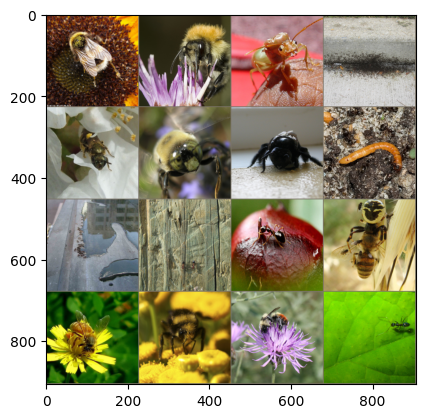

In [11]:
import matplotlib.pyplot as plt

# функция для наглядного просмотра выборки
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) #  C × H × W -> H × W × C
    mean = np.array([0.485, 0.456, 0.406]) # Undo the normalization
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # <3>
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs, nrow=4)
class_names = val_dataset.classes

outputs = model(inputs.to(device))
_, preds = torch.max(outputs,1) # “winning” class

imshow(out) #, title=[class_names[x] for x in preds])
print([class_names[x] for x in preds])

In [12]:
# сохранить модель
torch.save(model.state_dict(), "./resnet18.pt")

## Задание

* Выбрать свой датасет для классификации, лучше если там будет небольшое число классов и сам он небольшой по объёму (можно взять подмножество какого-то датасета)
* Взять предобученную сеть, лучше попробовать несколько, в том числе посовременнее
* Дотюнить её на выбранном датасете
* Попробовать разные значения гиперпараметов, разные модели
* (повышенная сложность) Попробуйте обучать не всю модель, а только последние слои (разное количество последних слоёв)
